
Seattle Fremont Bridge bike count data

Here again, is how we downloaded the bike data, but using a jupyter notebook instead of a python script executed by bash script in the Unix shell.

    Either re-download here, or edit path to where you saved it yesterday

Download data from here: https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k

Right click on 'CSV' and copy link location


In [1]:
# Version 1: Downloading the data
# This version will download the bike data every time we run the script
# This is unnecessary if you've already downloaded the file
from urllib.request import urlretrieve

URL = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'

# You can now download the data from the database
urlretrieve(URL, 'Fremont.csv')

('Fremont.csv', <http.client.HTTPMessage at 0x1f0dfecabe0>)

In [2]:
!head Fremont.csv

Date,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
10/03/2012 12:00:00 AM,9,4
10/03/2012 01:00:00 AM,6,4
10/03/2012 02:00:00 AM,1,1
10/03/2012 03:00:00 AM,3,2
10/03/2012 04:00:00 AM,1,6
10/03/2012 05:00:00 AM,10,21
10/03/2012 06:00:00 AM,50,105
10/03/2012 07:00:00 AM,95,257
10/03/2012 08:00:00 AM,146,291


In [5]:
import pandas as pd
data = pd.read_csv('Fremont.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2012-10-03 00:00:00,9.0,4.0
2012-10-03 01:00:00,6.0,4.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,3.0,2.0
2012-10-03 04:00:00,1.0,6.0


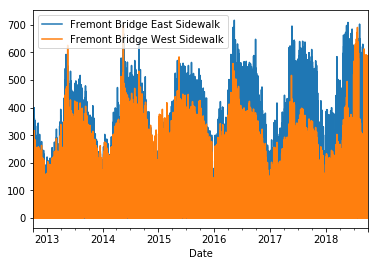

In [6]:
%matplotlib inline
data.plot()

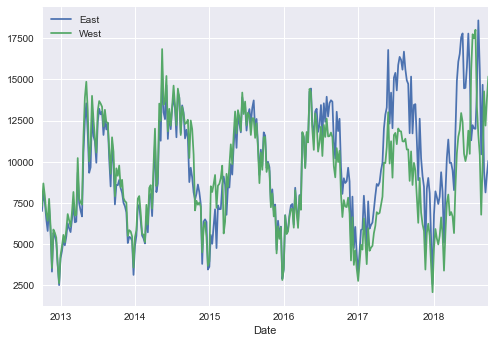

In [11]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
data.columns = ['East', 'West']
data.resample('W').sum().plot()

(0, 618365.34999999998)

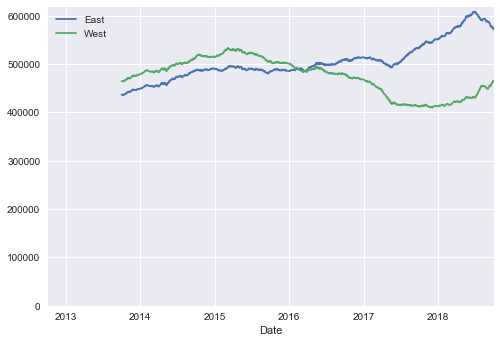

In [13]:
ax = data.resample('D').sum().rolling(365).sum().plot()
ax.set_ylim(0, None)

(0, 1080850.45)

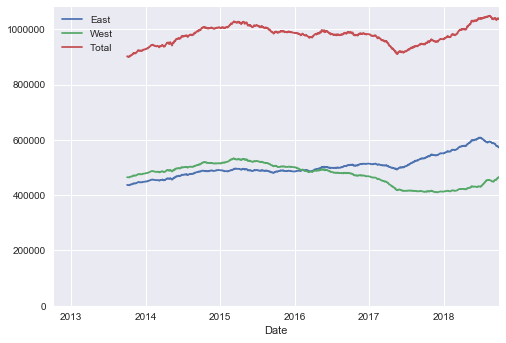

In [14]:
data['Total'] = data['West'] + data['East']
ax = data.resample('D').sum().rolling(365).sum().plot()
ax.set_ylim(0, None)

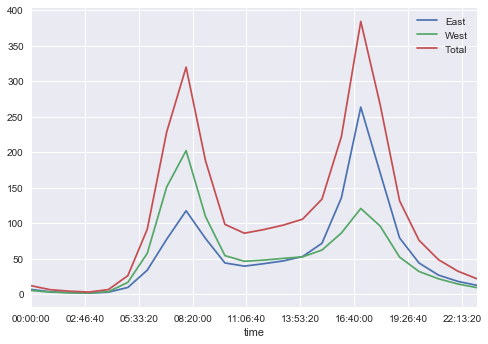

In [15]:
data.groupby(data.index.time).mean().plot()

In [20]:
pivoted = data.pivot_table('East', index = data.index.time, columns = data.index.date)
pivoted.iloc[:5, :5]

,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,9.0,11.0,7.0,7.0,5.0
01:00:00,6.0,0.0,4.0,5.0,5.0
02:00:00,1.0,6.0,3.0,2.0,1.0
03:00:00,3.0,3.0,2.0,2.0,2.0
04:00:00,1.0,1.0,2.0,1.0,2.0


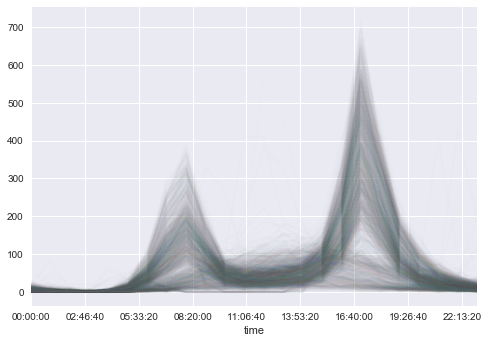

In [21]:
pivoted.plot(legend=False, alpha=0.01)